In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [31]:
#Importing Files
BEB_2015 = pd.read_csv("/content/drive/MyDrive/2015-building-energy-benchmarking.csv")
BEB_2016  = pd.read_csv("/content/drive/MyDrive/2016-building-energy-benchmarking.csv")
SM_2015 = pd.read_csv("/content/drive/MyDrive/socrata_metadata_2015-building-energy-benchmarking.json")
SM_2016  = pd.read_csv("/content/drive/MyDrive/socrata_metadata_2016-building-energy-benchmarking.json")

In [32]:
def NaN_and_Negative_Cleaning(df):

  #Changing category NaN values
  df['Outlier'] = df['Outlier'].fillna('Normal')
  df['ListOfAllPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].fillna('Other')
  df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna('Other')
  df['SecondLargestPropertyUseType'] = df['SecondLargestPropertyUseType'].fillna('None')
  df['ThirdLargestPropertyUseType'] = df['ThirdLargestPropertyUseType'].fillna('None')
  df['YearsENERGYSTARCertified'] = df['YearsENERGYSTARCertified'].fillna('None')
  df['DefaultData'] = df['DefaultData'].fillna('No')
  df = df.dropna(subset = ['TaxParcelIdentificationNumber'])

  #Setting negative values to the mean
  df = df.copy()
  df.loc[df["PropertyGFAParking"] < 0, "PropertyGFAParking"] = np.nanmean(df["PropertyGFAParking"])

  df = df.copy()
  df.loc[df["PropertyGFABuilding(s)"] < 0, "PropertyGFABuilding(s)"] = np.nanmean(df["PropertyGFABuilding(s)"])

  df = df.copy()
  df.loc[df["SourceEUI(kBtu/sf)"] < 0, "SourceEUI(kBtu/sf)"] = np.nanmean(df["SourceEUI(kBtu/sf)"])
  
  df = df.copy()
  df.loc[df["SourceEUIWN(kBtu/sf)"] < 0, "SourceEUIWN(kBtu/sf)"] = np.nanmean(df["SourceEUIWN(kBtu/sf)"])

  df = df.copy()
  df.loc[df["Electricity(kWh)"] < 0, "Electricity(kWh)"] = np.nanmean(df["Electricity(kWh)"])
  
  #Number of Buildings to be at least one
  df.loc[df["NumberofBuildings"] < 1, "NumberofBuildings"] = 1
 
  #Numeric Value Filling
  df.loc[(df["SecondLargestPropertyUseType"].isnull()), ["SecondLargestPropertyUseTypeGFA"]] = 0
  df.loc[(df["ThirdLargestPropertyUseType"].isnull()), ["ThirdLargestPropertyUseTypeGFA"]] = 0
  df['YearsENERGYSTARCertified'] = df['YearsENERGYSTARCertified'].fillna(value=0)
  df['ENERGYSTARScore'] = df['ENERGYSTARScore'].fillna(value=0)
  
  #Fill the rest of the NaN values with the mean
  df.fillna(df.mean(), inplace=True)

  return df

In [33]:
def Column_Tidying(df):

  #Dropping unnecessary columns
  df['Building_Age'] = df['DataYear'] - df['YearBuilt']
  df = df.drop(columns=['DataYear', 'YearBuilt', 'PropertyName', 'DefaultData', 
                        'CouncilDistrictCode', 'ComplianceStatus', 'Comment', 'Comments', 'ZipCode', 
                        'Address', 'City', 'State', 'Location', 'Zip Codes', '2010 Census Tracts', 
                        'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 
                        'SPD Beats', 'TaxParcelIdentificationNumber']) 

  #Neighborhood column tidying
  df['Neighborhood'] = df['Neighborhood'].str.upper()
  df["Neighborhood"] = df["Neighborhood"].replace (['DELRIDGE NEIGHBORHOODS'], 'DELRIDGE')

  return df

In [34]:
def Split_Lat_Long(df):

  #Spliting of Location column
  df[['0', 'Latitude', '2', 'Longitude','4', '5', '6', '7', '8', '9', 
      '10', '11', '12', '13', '14', '15', '16', '17', '18']] = df['Location'].str.split(n=-1, expand=True)

  #Dropping of unwanted columns
  df = df.drop(columns=['0', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18'])

  #Removal of unwanted symbols
  df['Longitude'] = df['Longitude'].str.replace(',','')
  df['Longitude'] = df['Longitude'].str.replace("'",'')
  df['Latitude'] = df['Latitude'].str.replace(',','')
  df['Latitude'] = df['Latitude'].str.replace("'",'')

  #Change columns to floats
  df['Latitude'] = df['Latitude'].astype(float)
  df['Longitude'] = df['Longitude'].astype(float)

  #Filling prior to combining datasets (otherwise conversion returns an error)
  df["NumberofBuildings"] = df["NumberofBuildings"].fillna(value=1)
  df["NumberofFloors"] = df["NumberofFloors"].fillna(value=1)

  #Conversion of columns to match type of other dataframe
  df['NumberofBuildings'] = df['NumberofBuildings'].astype(float)
  df['NumberofFloors'] = df['NumberofFloors'].astype(int)

  #Renaming columns to match name of other dataframe
  df.rename(columns = {'GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions'}, inplace = True)
  df.rename(columns = {'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity'}, inplace = True)

  return df

In [35]:
def Standard_Deviation(df, nstd):

  #Collect all numeric data into a dataframe
  df1 = df.select_dtypes (include = ["float64", "int64"])

  #Drop numeric columns apart from OSEBuildingID as it will be required for dataframe recombining 
  df = df.drop(columns=['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 
                        'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
                        'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 
                        'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 
                        'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 
                        'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Latitude', 'Longitude', 'Building_Age'])

  #Make a list of the columns
  cols = df1.columns.tolist()

  for i, column in enumerate(cols):

    #Delete data that is above nstd standard deviations from the mean
    df = df.copy()
    df1.drop(df1[df1[column] > (np.mean(df1[column])+(nstd*(np.std(df1[column]))))].index, inplace = True)

    #Delete data that is below nstd standard deviations from the mean
    df = df.copy()
    df1.drop(df1[df1[column] < (np.mean(df1[column])-nstd*(np.std(df1[column])))].index, inplace = True)

  #Recombining dataframe
  df2 = pd.merge(df1, df, how="left", on='OSEBuildingID')

  return df2

In [36]:
def Isolation_Forest_Plot(df):

  #Collect all numeric data into a dataframe
  df = df.select_dtypes (include = ["float64", "int64"])

  #Make a list of the columns
  cols = df.columns.tolist()

  #Number and size of graphs 
  fig, axs = plt.subplots(6, 5, figsize=(22, 12), facecolor='w', edgecolor='k')
  axs = axs.ravel()

  for i, column in enumerate(cols):
      isolation_forest = IsolationForest(n_estimators=100,  contamination=0.01, random_state=42, max_samples=200)
      isolation_forest.fit(df[column].values.reshape(-1,1))

      required = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
      anomaly_score = isolation_forest.decision_function(required)
      outlier = isolation_forest.predict(required)
    
      axs[i].plot(required, anomaly_score, label='anomaly score')

      axs[i].fill_between(required.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                       where=outlier==-1, color='r', 
                       alpha=.4, label='outlier region')
      axs[i].legend()
      axs[i].set_title(column)

In [37]:
pd.set_option("display.max_columns", None)
BEB_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [38]:
BEB_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [39]:
BEB_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [40]:
BEB_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [41]:
BEB_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [42]:
pd.set_option("display.max_columns", None)
BEB_2015.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
count,3340.000000,3340.0,3340.000000,3340.000000,3340.000000,3332.000000,3.340000e+03,3340.000000,3.340000e+03,3.204000e+03,1559.000000,560.000000,2560.000000,3330.000000,3330.000000,3330.000000,3330.000000,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3330.000000,224.000000,3338.000000,213.000000,3338.000000,3340.000000
mean,20522.168263,2015.0,4.450898,1967.624850,1.035629,4.682173,9.077289e+04,11054.032335,7.971886e+04,7.488154e+04,27675.646568,10755.708929,67.894141,53.626126,57.586547,132.779730,138.936036,4.983106e+06,5.203055e+06,2.502851e+05,1.017897e+06,3.473209e+06,1.253304e+04,1.253304e+06,7.142301e+03,110.094102,0.985339,123.062500,32.380168,1.347418,24.825644,18786.680240
std,11511.515874,0.0,2.127203,32.949847,0.784463,5.458460,1.493058e+05,35296.330507,1.292314e+05,1.236249e+05,52480.843425,22618.529737,27.154057,53.893311,55.604963,131.943223,131.359121,1.375330e+07,1.400757e+07,3.481900e+06,2.789931e+06,9.519639e+06,4.415142e+04,4.415142e+06,1.962790e+05,409.450179,1.637172,5.812128,19.907567,0.477272,15.006287,588.604192
min,1.000000,2015.0,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,-3.000000,-5.055000e+04,5.872000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,-2.000000,-2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,116.000000,1.000000,1.000000,1.000000,17916.000000
25%,19921.750000,2015.0,3.000000,1947.000000,1.000000,2.000000,2.848700e+04,0.000000,2.668300e+04,2.500000e+04,4959.000000,2385.250000,51.750000,27.300000,29.700000,73.500000,80.300000,9.139300e+05,9.883248e+05,0.000000e+00,1.864908e+05,6.363322e+05,0.000000e+00,0.000000e+00,0.000000e+00,9.265000,0.080000,117.000000,14.000000,1.000000,10.000000,18379.000000
50%,22977.000000,2015.0,4.000000,1973.000000,1.000000,4.000000,4.385500e+04,0.000000,4.132600e+04,3.900000e+04,10600.000000,5019.500000,76.000000,37.400000,40.900000,95.000000,102.800000,1.776219e+06,1.953996e+06,0.000000e+00,3.400320e+05,1.160236e+06,2.945500e+03,2.945770e+05,0.000000e+00,32.740000,0.460000,123.000000,33.000000,1.000000,26.000000,18390.000000
75%,25748.000000,2015.0,7.000000,1996.000000,1.000000,5.000000,8.842800e+04,4304.250000,7.872600e+04,7.206750e+04,26224.500000,10275.000000,90.000000,59.875000,65.575000,143.900000,151.275000,4.044277e+06,4.368462e+06,0.000000e+00,8.061935e+05,2.750847e+06,1.115325e+04,1.115366e+06,0.000000e+00,88.642500,1.180000,125.500000,50.000000,2.000000,38.000000,19576.000000
max,50059.000000,2015.0,7.000000,2015.000000,39.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,686750.000000,303910.000000,100.000000,800.600000,800.600000,2511.100000,2511.000000,2.958126e+08,2.977410e+08,1.278697e+08,8.344505e+07,2.847263e+08,1.364484e+06,1.364484e+08,8.269669e+06,11824.890000,31.380000,135.000000,61.000000,2.000000,51.000000,19584.000000


In [43]:
BEB_2015 = Split_Lat_Long(BEB_2015)

In [44]:
BEB_2015.Latitude = BEB_2015.Latitude.round(5)
BEB_2015.Longitude = BEB_2015.Longitude.round(5)

BEB_2016.Latitude = BEB_2016.Latitude.round(5)
BEB_2016.Longitude = BEB_2016.Longitude.round(5)

In [45]:
frames = [BEB_2015, BEB_2016]

Combined_df = pd.concat(frames)

In [46]:
Combined_df.shape

(6716, 54)

In [47]:
Combined_df.drop_duplicates(subset=['OSEBuildingID'], inplace=True, ignore_index=True)

In [48]:
Combined_df = NaN_and_Negative_Cleaning(Combined_df)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [49]:
Combined_df = Column_Tidying(Combined_df)

In [50]:
Combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3430 entries, 0 to 3431
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3430 non-null   int64  
 1   BuildingType                     3430 non-null   object 
 2   PrimaryPropertyType              3430 non-null   object 
 3   Neighborhood                     3430 non-null   object 
 4   NumberofBuildings                3430 non-null   float64
 5   NumberofFloors                   3430 non-null   int64  
 6   PropertyGFATotal                 3430 non-null   int64  
 7   PropertyGFAParking               3430 non-null   float64
 8   PropertyGFABuilding(s)           3430 non-null   float64
 9   ListOfAllPropertyUseTypes        3430 non-null   object 
 10  LargestPropertyUseType           3430 non-null   object 
 11  LargestPropertyUseTypeGFA        3430 non-null   float64
 12  SecondLargestPropert

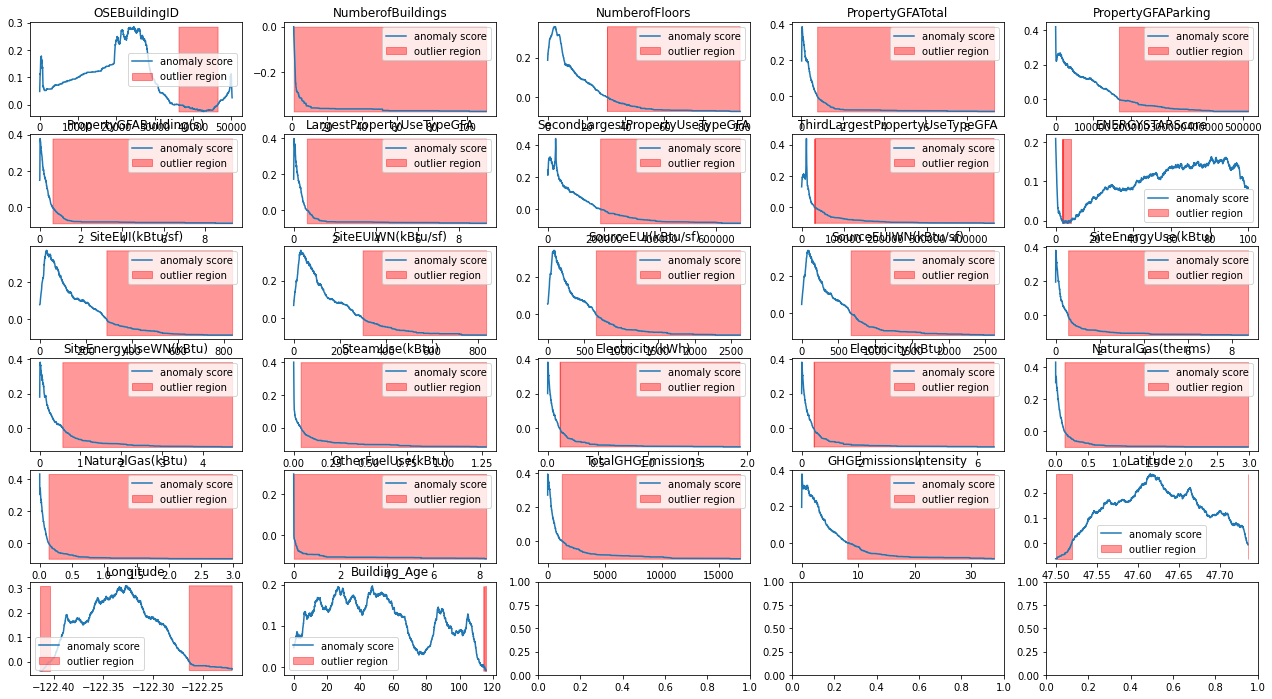

In [51]:
Isolation_Forest_Plot(Combined_df)

In [52]:
Combined_df.shape

(3430, 36)

In [53]:
# nstd is the number of standard deviations from the mean that you would like to remove from the data
nstd = 3

Cleaned_df = Standard_Deviation(Combined_df, nstd)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [54]:
Cleaned_df.shape

(2253, 36)

In [55]:
Cleaned_df.to_csv('/content/drive/MyDrive/Cleaned_df.csv')